In [4]:
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.feature as cfeature
import cartopy.crs as ccrs

import plotting_utils as pu
import overview_plot_utils as opu
import sa_city_utils as sacu

from utils import roar_data_path as project_data_path
from utils import gev_metric_ids, trend_metric_ids
from utils import city_list

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [5]:
# Set fonts
from matplotlib import font_manager
font_dirs = ["/storage/home/dcl5300/fonts"]

font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["axes.linewidth"] = 1.5

## Useful plotting functions

In [6]:
def plot_city_metrics(city, metric_ids, plot_col, fit_method, stationary, limits=None, store=True, legend=0, read_samples=True, title=None):
    # Make axes
    fig, axs = plt.subplots(2, len(metric_ids), height_ratios=[4, 1], figsize=(4*len(metric_ids),11))
    fig.suptitle(f"{pu.city_names[city]} {title}", fontweight='bold', fontsize=14)

    # Loop through examples
    for idx, metric_id in enumerate(metric_ids):
        axs_subset = axs[:,idx]

        pu.plot_city_results(
            city = city,
            metric_id = metric_id,
            plot_col = plot_col,
            fit_method = fit_method,
            stationary = stationary,
            axs = axs_subset,
            read_samples = read_samples,
            limits = limits[idx] if type(limits) == list else None,
            yticklabels = True if idx == 0 else False,
            legend = True if idx == legend else False,
        )

    plt.tight_layout()
    
    if store:
        plt.savefig(f'../figs/si/{city}_{plot_col}_{fit_method}_{stationary}_{hist_slice}_{proj_slice}.pdf')
    else:
        plt.show()

# Checks

### All cities

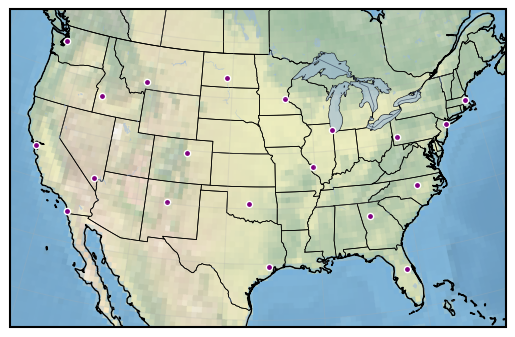

In [30]:
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.LambertConformal()))

for coords in city_list.values():
    ax.scatter(x=coords[1], y=coords[0], transform=ccrs.PlateCarree(), color='purple', edgecolor='white', zorder=2, s=20)

# Tidy
ax.coastlines()
gl = ax.gridlines(draw_labels=False, x_inline=False, rotate_labels=False, alpha=0.2)
ax.add_feature(cfeature.STATES, edgecolor="black", linewidth=0.5)
ax.add_feature(cfeature.BORDERS, edgecolor="black", linewidth=0.5)
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.set_extent([-120, -73, 22, 51], ccrs.Geodetic())
ax.stock_img()
plt.show()

### Robustness checks

In [7]:
# Stationary check
n_boot_hist = 1
sample_str = "_samples"
stationary = 'stat'
fit_method = 'lmom'
proj_slice = '2050-2100'
hist_slice = '1950-2014'
plot_col = '100yr_return_level_diff'

df_check = pd.DataFrame()

for city in city_list.keys():
    for metric_id in gev_metric_ids[:3]:
        # Read all
        try:
            df_1000 = pd.read_csv(f"{project_data_path}/extreme_value/cities/original_grid/freq/{city}_{metric_id}_{hist_slice}_{proj_slice}_{fit_method}_{stationary}_nbootproj1000_nboothist{n_boot_hist}{sample_str}.csv")
            uc_1000 = sacu.calculate_df_uc(df_1000, plot_col).set_index('uncertainty_type')
            df_100 = pd.read_csv(f"{project_data_path}/extreme_value/cities/original_grid/freq/{city}_{metric_id}_{hist_slice}_{proj_slice}_{fit_method}_{stationary}_nbootproj100_nboothist{n_boot_hist}{sample_str}.csv")
            uc_100 = sacu.calculate_df_uc(df_100, plot_col).set_index('uncertainty_type')
        except Exception as e:
            continue

        # Append
        df_tmp = pd.DataFrame(data={'city': [city, city],
                                    'metric_id': [metric_id, metric_id],
                                    'n_boot': [100, 1000],
                                    'fit_uc_mean': [uc_100.loc['fit_uc']['mean'],
                                                    uc_1000.loc['fit_uc']['mean']],
                                    'fit_uc_std': [uc_100.loc['fit_uc']['std'],
                                                   uc_1000.loc['fit_uc']['std']]},
                              index=[0,1])
        df_check = pd.concat([df_check, df_tmp], ignore_index=True)

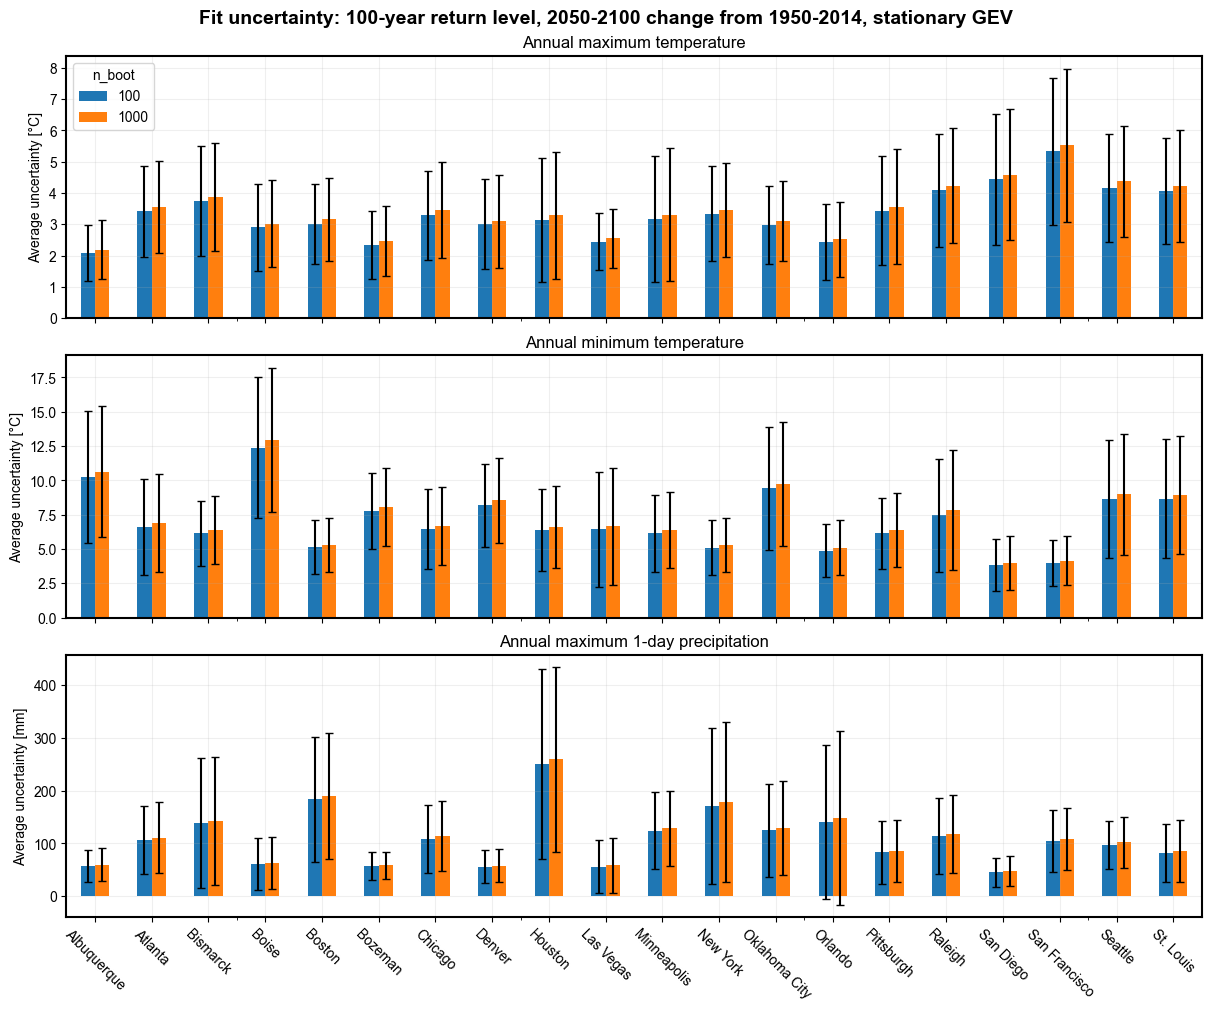

In [8]:
# Plot
fig, axs = plt.subplots(3,1, figsize=(12,10), layout='constrained', sharex=True)

for idx, metric_id in enumerate(gev_metric_ids[:3]):
    ax = axs[idx]
    dfp = df_check[df_check['metric_id'] == metric_id].pivot(index='city', columns='n_boot', values='fit_uc_mean')
    yerr = df_check[df_check['metric_id'] == metric_id].pivot(index='city', columns='n_boot', values='fit_uc_std')
    dfp.plot(kind='bar', rot=0, capsize=3, ax=ax, yerr=yerr)
    ax.grid(alpha=0.2)
    ax.set_xticklabels([pu.city_names[city] for city in dfp.index], rotation=-45)
    ax.set_xlabel('')
    ax.set_title(pu.title_labels[metric_id])
    ax.set_ylabel(f"Average uncertainty {pu.gev_labels[metric_id]}")
    if idx != 0:
        ax.get_legend().remove()

fig.suptitle('Fit uncertainty: 100-year return level, 2050-2100 change from 1950-2014, stationary GEV', fontweight='bold', fontsize=14)
plt.savefig('../figs/si/city_nboot_check_stat_change.pdf', bbox_inches='tight')

In [41]:
# Non-stationary check
sample_str = "_samples"
stationary = 'nonstat_scale'
fit_method = 'mle'
proj_slice = '1950-2100'
plot_col = '100yr_return_level_diff_2075-1975'

df_check = pd.DataFrame()

for city in city_list.keys():
    for metric_id in gev_metric_ids[:3]:
        # Read all
        try:
            df_1000 = pd.read_csv(f"{project_data_path}/extreme_value/cities/original_grid/freq/{city}_{metric_id}_{proj_slice}_{fit_method}_{stationary}_nboot1000{sample_str}.csv")
            df_100 = pd.read_csv(f"{project_data_path}/extreme_value/cities/original_grid/freq/{city}_{metric_id}_{proj_slice}_{fit_method}_{stationary}_nboot100{sample_str}.csv")
            # Drop bad fits
            if city == 'orlando':
                drop = (df_1000['ensemble'] == 'STAR-ESDM') & (df_1000['gcm'] == 'BCC-CSM2-MR')
                df_1000 = df_1000[~drop].copy()
                
                drop = (df_100['ensemble'] == 'STAR-ESDM') & (df_100['gcm'] == 'BCC-CSM2-MR')
                df_100 = df_100[~drop].copy()
                
            uc_1000 = sacu.calculate_df_uc(df_1000, plot_col).set_index('uncertainty_type')
            uc_100 = sacu.calculate_df_uc(df_100, plot_col).set_index('uncertainty_type')
        except Exception as e:
            continue

        # Append
        df_tmp = pd.DataFrame(data={'city': [city, city],
                                    'metric_id': [metric_id, metric_id],
                                    'n_boot': [100, 1000],
                                    'fit_uc_mean': [uc_100.loc['fit_uc']['mean'],
                                                    uc_1000.loc['fit_uc']['mean']],
                                    'fit_uc_std': [uc_100.loc['fit_uc']['std'],
                                                   uc_1000.loc['fit_uc']['std']]},
                              index=[0,1])
        df_check = pd.concat([df_check, df_tmp], ignore_index=True)

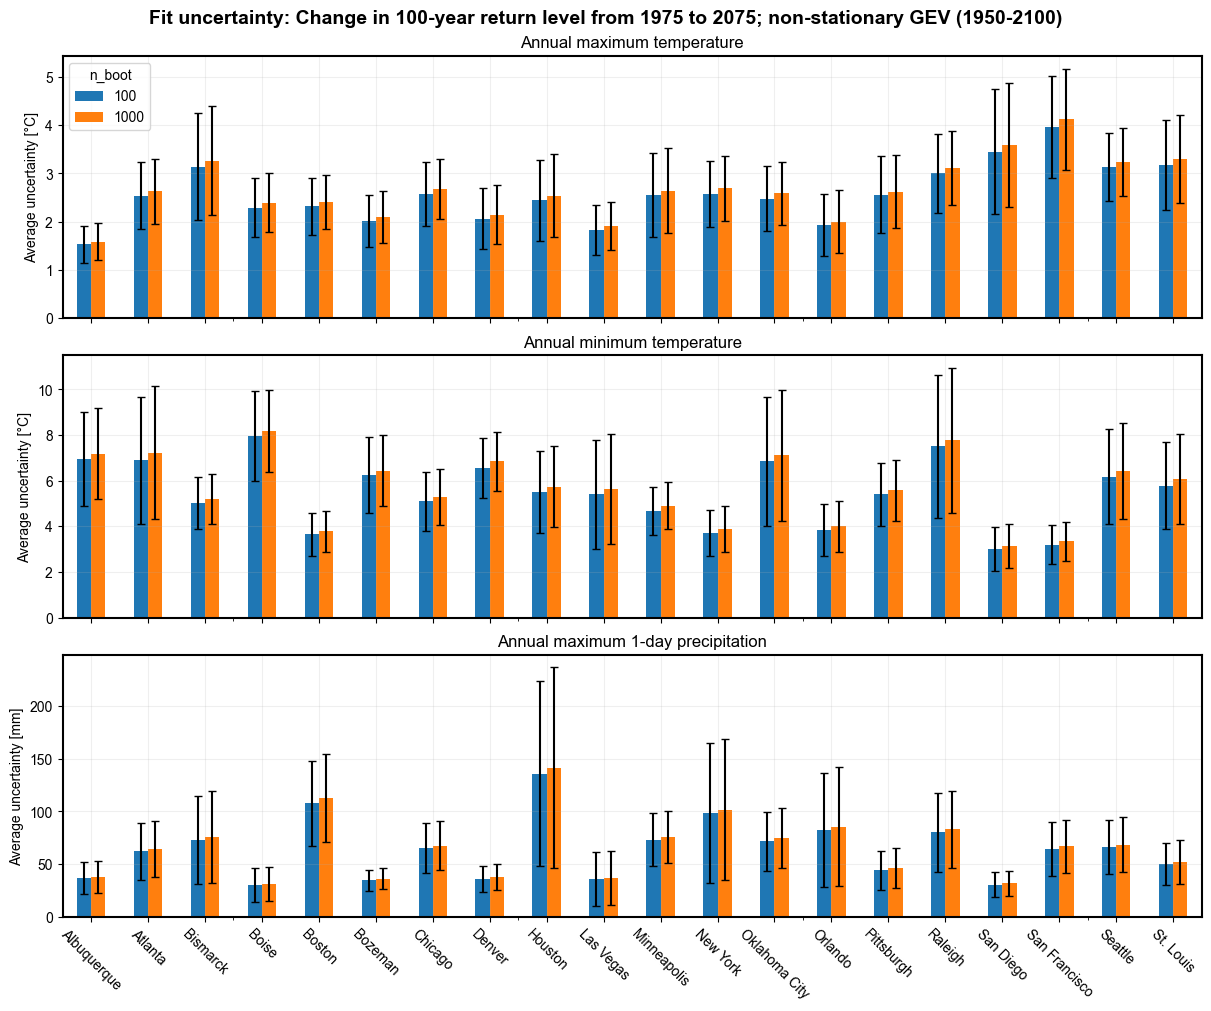

In [42]:
# Plot
fig, axs = plt.subplots(3,1, figsize=(12,10), layout='constrained', sharex=True)

for idx, metric_id in enumerate(gev_metric_ids[:3]):
    ax = axs[idx]
    dfp = df_check[df_check['metric_id'] == metric_id].pivot(index='city', columns='n_boot', values='fit_uc_mean')
    yerr = df_check[df_check['metric_id'] == metric_id].pivot(index='city', columns='n_boot', values='fit_uc_std')
    dfp.plot(kind='bar', rot=0, capsize=3, ax=ax, yerr=yerr)
    ax.grid(alpha=0.2)
    ax.set_xticklabels([pu.city_names[city] for city in dfp.index], rotation=-45)
    ax.set_xlabel('')
    ax.set_title(pu.title_labels[metric_id])
    ax.set_ylabel(f"Average uncertainty {pu.gev_labels[metric_id]}")
    if idx != 0:
        ax.get_legend().remove()

fig.suptitle('Fit uncertainty: Change in 100-year return level from 1975 to 2075; non-stationary GEV (1950-2100)', fontweight='bold', fontsize=14)
plt.savefig('../figs/si/city_nboot_check_nonstat_diff.pdf', bbox_inches='tight')

### Cities

In [ ]:
city = 'boston'
plot_col = '100yr_return_level_2075'
fit_method = 'mle'
stationary = False

metric_ids = ['max_tasmax', 'min_tasmin', 'max_pr']

plot_city_metrics(city, metric_ids, plot_col, fit_method, stationary,
                  title = '(non-stationary GEV, 2075)',
                  legend=1)

In [ ]:
city = 'boston'
plot_col = '100yr_return_level_diff_2075-1975'
fit_method = 'mle'
stationary = False

metric_ids = ['max_tasmax', 'min_tasmin', 'max_pr']

plot_city_metrics(city, metric_ids, plot_col, fit_method, stationary,
                  title = '(non-stationary GEV, change from 1975 to 2075)',
                  legend=1)

In [ ]:
city = 'chicago'
plot_col = '100yr_return_level_proj'
fit_method = 'lmom'
stationary = True

metric_ids = ['max_tasmax', 'min_tasmin', 'max_pr']

plot_city_metrics(city, metric_ids, plot_col, fit_method, stationary,
                  title = '(stationary GEV, 2050-2100)',
                  legend=1)

In [ ]:
city = 'chicago'
plot_col = '100yr_return_level_diff'
fit_method = 'lmom'
stationary = True

metric_ids = ['max_tasmax', 'min_tasmin', 'max_pr']

plot_city_metrics(city, metric_ids, plot_col, fit_method, stationary,
                  title = '(stationary GEV, 2050-2100 change from 1950-2014)',
                  legend=1)

# Regionalization

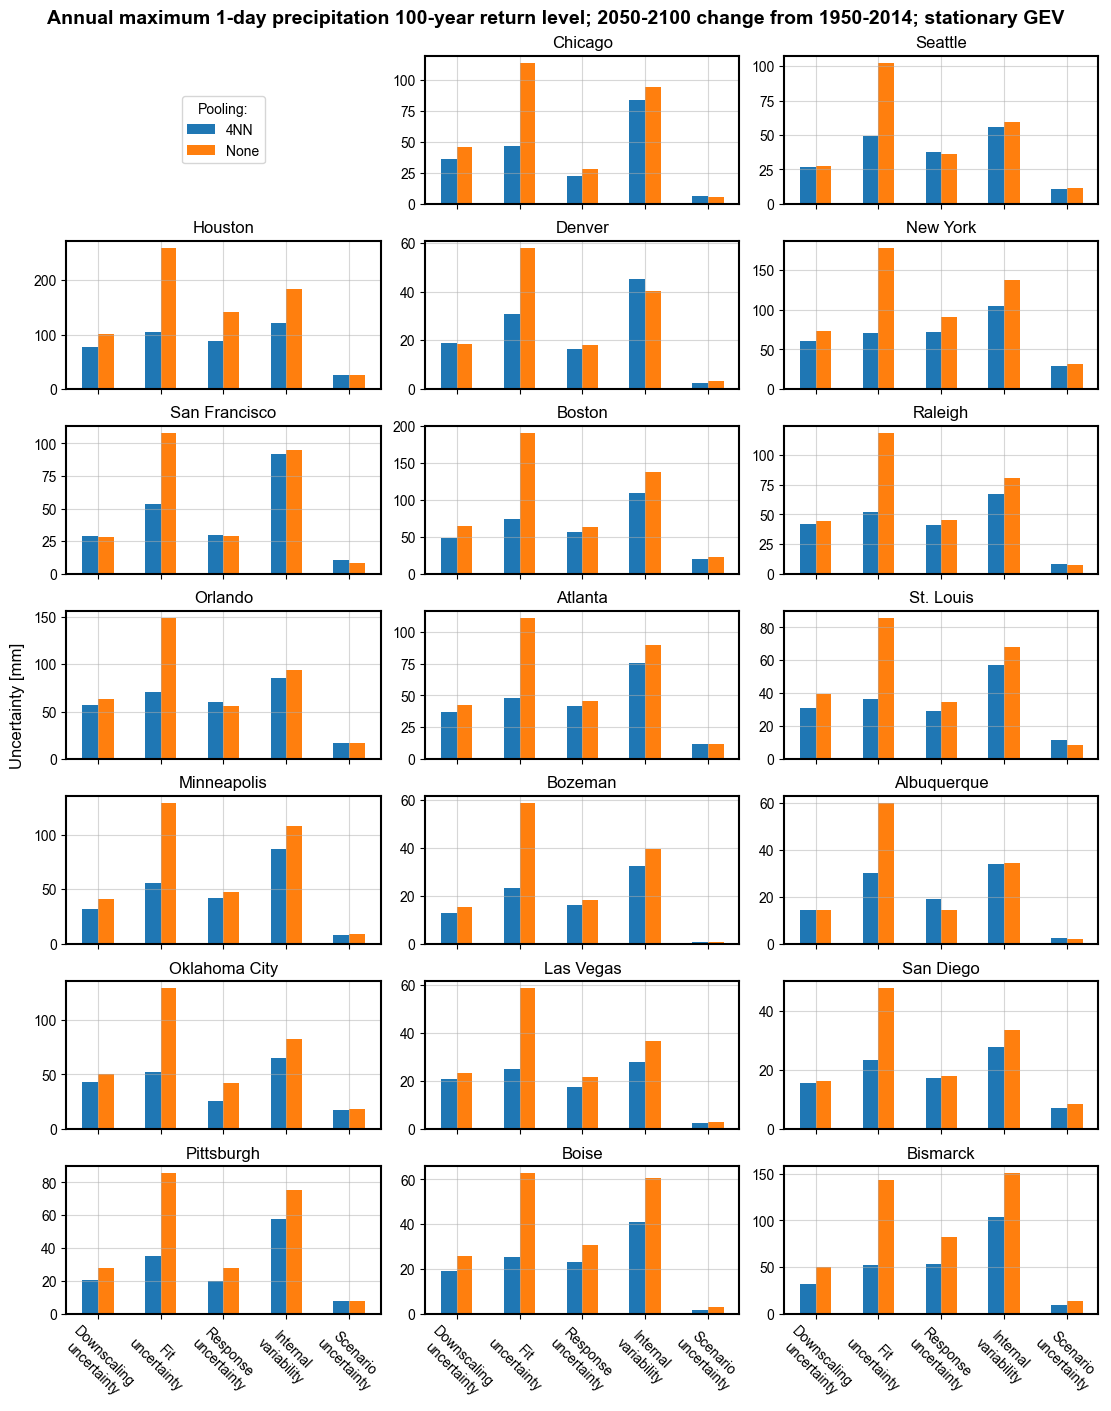

In [15]:
plt.rcParams["font.size"] = 10

# Plot
plot_col = '100yr_return_level_diff'

# cities = ['boston', 'chicago', 'denver', 'houston', 'nyc']
cities = list(city_list.keys())
metric_id = 'max_pr'

fig, axs = plt.subplots(7, 3,
                        figsize=(11,14), 
                        layout='constrained',
                        sharex=False)
axs = axs.flatten()

for idc, city in enumerate(cities):
    ax = axs[idc+1]
    # Read example
    df_main = pd.read_csv(f'{project_data_path}/extreme_value/cities/original_grid/freq/{city}_{metric_id}_1950-2014_2050-2100_lmom_stat_nbootproj1000_nboothist1_samples.csv')
    df_neighbors = pd.read_csv(f'{project_data_path}/extreme_value/cities/original_grid/freq/{city}_{metric_id}_1950-2014_2050-2100_lmom_stat_nbootproj1000_nboothist1_samples_neighbors.csv')
    
    # Get main
    df_res_main = sacu.calculate_df_uc(df_main, '100yr_return_level_diff')
    df_res_main['pooling'] = 'None'
    
    # Get neighbors
    df_res_neighbors = sacu.calculate_df_uc(df_neighbors, '100yr_return_level_diff')
    df_res_neighbors['pooling'] = '4NN'
    
    df_res = pd.concat([df_res_main, df_res_neighbors], ignore_index=True)
    
    # Plot
    df_res_plot = df_res[df_res["uncertainty_type"].isin(pu.uc_labels.keys())].pivot(
        index='uncertainty_type',
        columns='pooling',
        values='mean')
    
    df_res_plot.plot.bar(ax=ax)

    # Tidy
    ax.set_xticklabels('')
    ax.set_xlabel('')
    ax.grid(alpha=0.5)
    ax.set_ylabel('')
    ax.set_title(pu.city_names[city])
    handles, labels = ax.get_legend_handles_labels()
    ax.get_legend().remove()

# Single legend
axs[0].set_axis_off()
axs[0].legend(handles=handles, labels=labels, loc='center', title='Pooling:')

for ax in axs[-3:]:
    ax.set_xticklabels([pu.uc_labels[uc_type].replace(" ", "\n") for uc_type in df_res_plot.index], rotation=-45)

fig.supylabel(f"Uncertainty {pu.gev_labels[metric_id]}")
fig.suptitle(f'{pu.title_labels[metric_id]} 100-year return level; 2050-2100 change from 1950-2014; stationary GEV', fontweight='bold', fontsize=14)

plt.savefig(f'../figs/si/{metric_id}_city_4nn_check_stat_change.pdf', bbox_inches='tight')

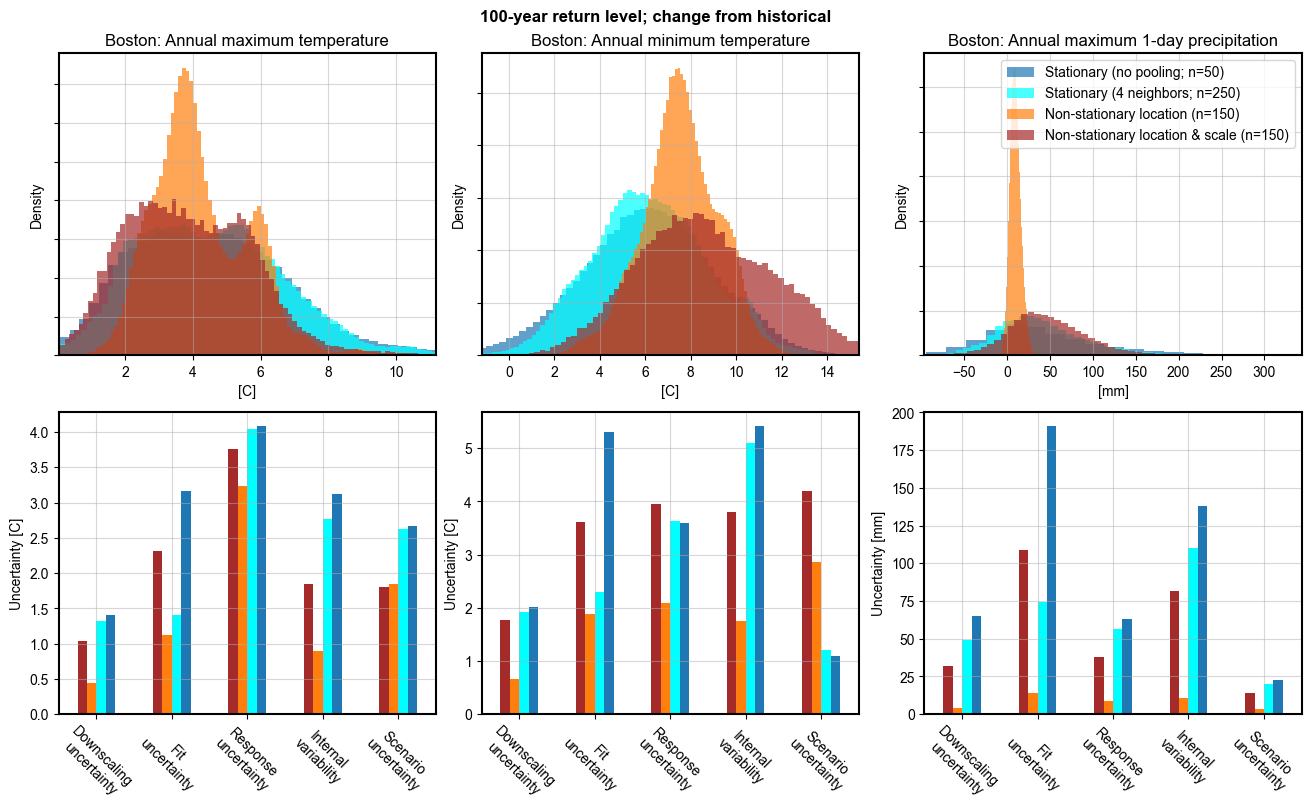

In [14]:
# Plot
stat_plot_col = '100yr_return_level_diff'
nonstat_plot_col = '100yr_return_level_diff_2075-1975'

city = 'boston'
metric_ids = ['max_tasmax', 'min_tasmin', 'max_pr']

fig, axs = plt.subplots(2, len(metric_ids),
                        figsize=(13,8), 
                        layout='constrained')

for idm, metric_id in enumerate(metric_ids):
    # Read metrics
    df_stat_main = pd.read_csv(f'{project_data_path}/extreme_value/cities/original_grid/freq/{city}_{metric_id}_1950-2014_2050-2100_lmom_stat_nbootproj1000_nboothist1_samples.csv')
    df_stat_neighbors = pd.read_csv(f'{project_data_path}/extreme_value/cities/original_grid/freq/{city}_{metric_id}_1950-2014_2050-2100_lmom_stat_nbootproj1000_nboothist1_samples_neighbors.csv')
    df_nonstat_loc = pd.read_csv(f'{project_data_path}/extreme_value/cities/original_grid/freq/{city}_{metric_id}_1950-2100_mle_nonstat_nboot1000_samples.csv')
    df_nonstat_loc_scale = pd.read_csv(f'{project_data_path}/extreme_value/cities/original_grid/freq/{city}_{metric_id}_1950-2100_mle_nonstat_nboot100_samples_scale.csv')
    
    # Fix nonstat tasmin
    if metric_id == 'min_tasmin':
        df_nonstat_loc.loc[df_nonstat_loc["n_boot"] != "main", nonstat_plot_col] = -df_nonstat_loc.loc[df_nonstat_loc["n_boot"] != "main", nonstat_plot_col]
    
    # Plot hist
    ax = axs[0, idm]
    df_stat_main[stat_plot_col].plot.hist(ax=ax, bins=100, alpha=0.7, color='C0', label='Stationary (no pooling; n=50)', density=True)
    df_stat_neighbors[stat_plot_col].plot.hist(ax=ax, bins=100, alpha=0.7, color='aqua', label='Stationary (4 neighbors; n=250)', density=True)
    df_nonstat_loc[nonstat_plot_col].plot.hist(ax=ax, bins=100, alpha=0.7, color='C1', label='Non-stationary location (n=150)', density=True)
    df_nonstat_loc_scale[nonstat_plot_col].plot.hist(ax=ax, bins=100, alpha=0.7, color='brown', label='Non-stationary location & scale (n=150)', density=True)
    
    # Tidy
    ax.grid(alpha=0.5)
    ax.set_ylabel('Density')
    ax.set_yticklabels([])
    ax.set_title(f"{pu.city_names[city]}: {pu.title_labels[metric_id]}")
    ax.set_xlabel(f'{pu.gev_labels[metric_id]}')
    
    xlim_upper = np.max([df_stat_main[stat_plot_col].quantile(0.99),
                      df_stat_neighbors[stat_plot_col].quantile(0.99),
                      df_nonstat_loc[nonstat_plot_col].quantile(0.99),
                        df_nonstat_loc_scale[nonstat_plot_col].quantile(0.99)])
    
    xlim_lower = np.min([df_stat_main[stat_plot_col].quantile(0.01),
                      df_stat_neighbors[stat_plot_col].quantile(0.01),
                      df_nonstat_loc[nonstat_plot_col].quantile(0.01),
                     df_nonstat_loc_scale[nonstat_plot_col].quantile(0.01)])
    ax.set_xlim([xlim_lower, xlim_upper])
    
    if idm == 2:
        ax.legend()

    # Plot UC
    ax = axs[1, idm]
    # Get UC
    df_res_stat_main = sacu.calculate_df_uc(df_stat_main, stat_plot_col)
    df_res_stat_main['label'] = 'Stationary (no pooling; n=50)'

    df_res_stat_neighbors = sacu.calculate_df_uc(df_stat_neighbors, stat_plot_col)
    df_res_stat_neighbors['label'] = 'Stationary (4 neighbors; n=250)'

    df_res_nonstat_loc = sacu.calculate_df_uc(df_nonstat_loc, nonstat_plot_col)
    df_res_nonstat_loc['label'] = 'Non-stationary location (n=150)'

    df_res_nonstat_loc_scale = sacu.calculate_df_uc(df_nonstat_loc_scale, nonstat_plot_col)
    df_res_nonstat_loc_scale['label'] = 'Non-stationary location & scale (n=150)'

    df_res = pd.concat([df_res_stat_main,
                        df_res_stat_neighbors,
                        df_res_nonstat_loc,
                        df_res_nonstat_loc_scale],
                       ignore_index=True)

    # Plot
    df_res_plot = df_res[df_res["uncertainty_type"].isin(pu.uc_labels.keys())].pivot(
        index='uncertainty_type',
        columns='label',
        values='mean'
    )

    df_res_plot.plot.bar(ax=ax, color=['brown', 'C1', 'aqua', 'C0'])
    ax.set_xticklabels([pu.uc_labels[uc_type].replace(" ", "\n") for uc_type in df_res_plot.index], rotation=-45)
    ax.set_xlabel('')
    ax.grid(alpha=0.5)
    ax.set_ylabel(f'Uncertainty {pu.gev_labels[metric_id]}')
    ax.get_legend().remove()

fig.suptitle('100-year return level; change from historical', fontweight='bold')

plt.show()

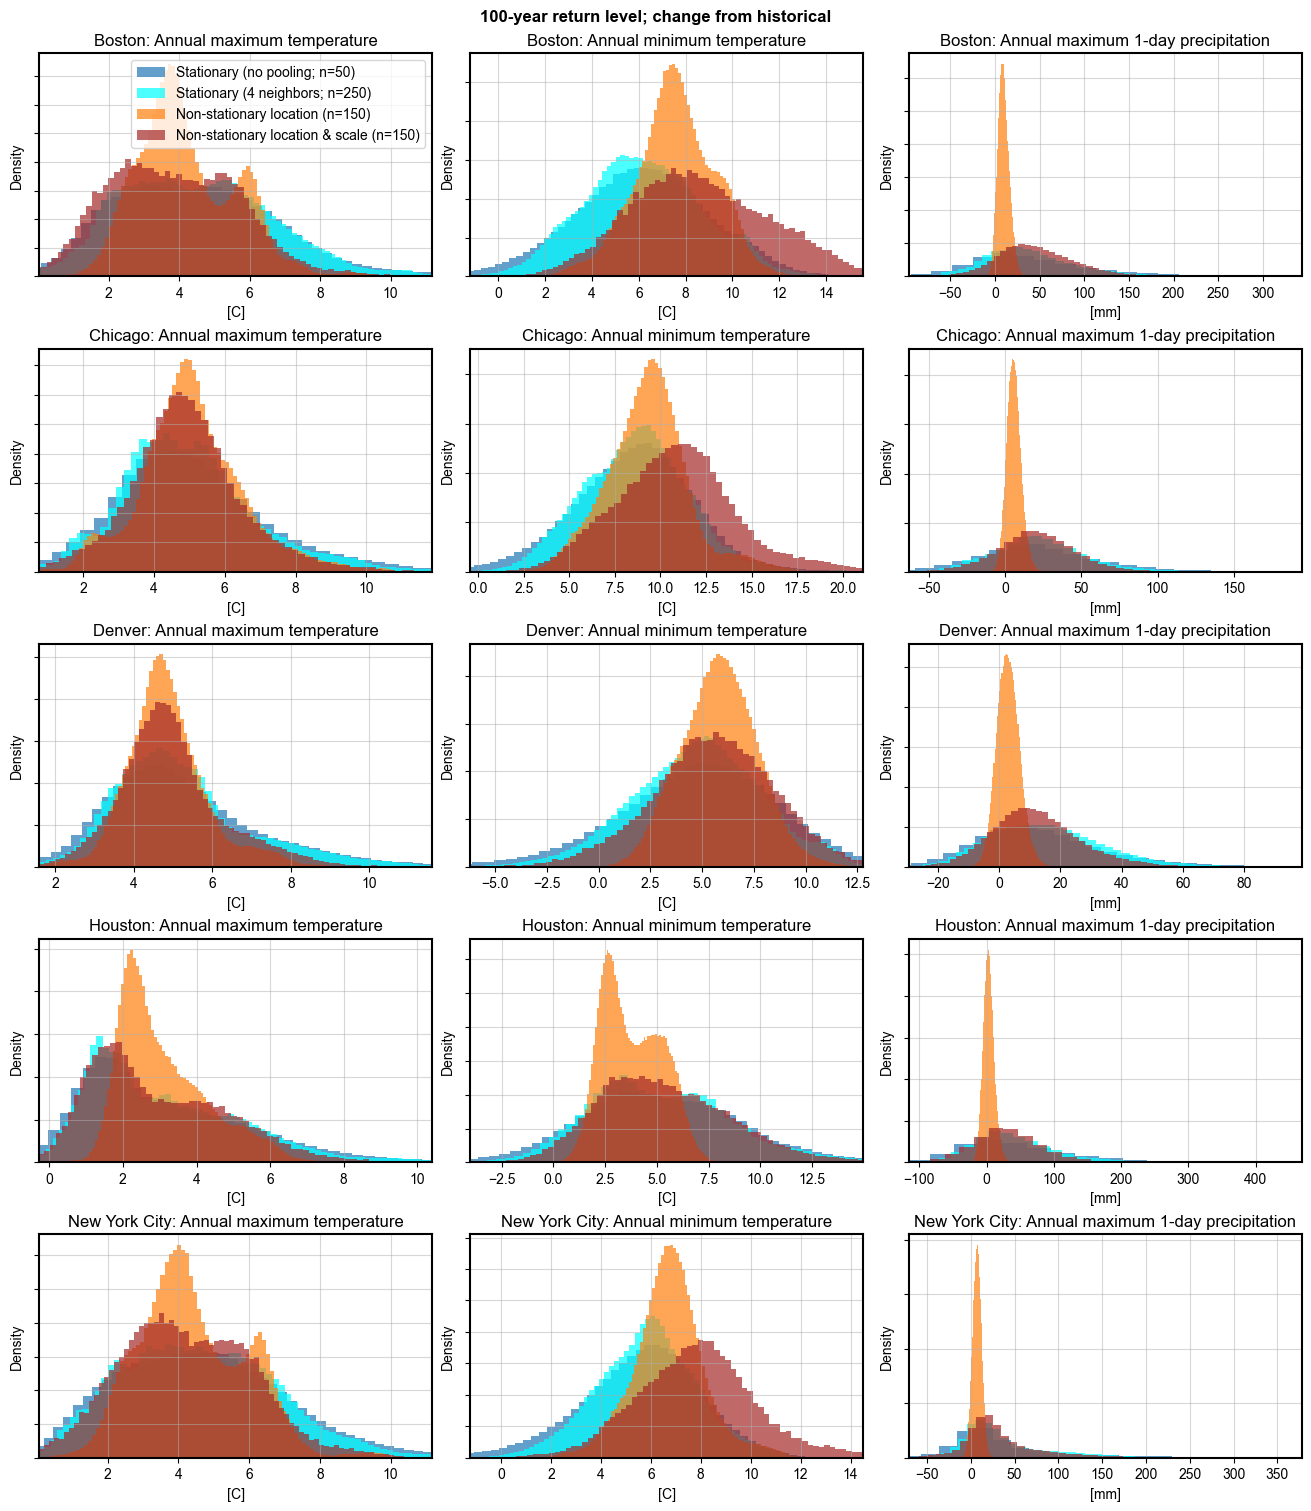

In [34]:
# Plot
stat_plot_col = '100yr_return_level_diff'
nonstat_plot_col = '100yr_return_level_diff_2075-1975'

cities = ['boston', 'chicago', 'denver', 'houston', 'nyc']
metric_ids = ['max_tasmax', 'min_tasmin', 'max_pr']

fig, axs = plt.subplots(len(cities), len(metric_ids),
                        figsize=(13,15), 
                        layout='constrained')

for idc, city in enumerate(cities):
    for idm, metric_id in enumerate(metric_ids):
        ax = axs[idc, idm]
        # Read example
        df_stat_main = pd.read_csv(f'{project_data_path}/extreme_value/cities/original_grid/freq/{city}_{metric_id}_1950-2014_2050-2100_lmom_stat_nbootproj1000_nboothist1_samples.csv')
        df_stat_neighbors = pd.read_csv(f'{project_data_path}/extreme_value/cities/original_grid/freq/{city}_{metric_id}_1950-2014_2050-2100_lmom_stat_nbootproj1000_nboothist1_samples_neighbors.csv')
        df_nonstat_loc = pd.read_csv(f'{project_data_path}/extreme_value/cities/original_grid/freq/{city}_{metric_id}_1950-2100_mle_nonstat_nboot1000_samples.csv')
        df_nonstat_loc_scale = pd.read_csv(f'{project_data_path}/extreme_value/cities/original_grid/freq/{city}_{metric_id}_1950-2100_mle_nonstat_scale_nboot100_samples.csv')

        # Fix nonstat tasmin
        if metric_id == 'min_tasmin':
            df_nonstat_loc.loc[df_nonstat_loc["n_boot"] != "main", nonstat_plot_col] = -df_nonstat_loc.loc[df_nonstat_loc["n_boot"] != "main", nonstat_plot_col]

        # Plot
        df_stat_main[stat_plot_col].plot.hist(ax=ax, bins=100, alpha=0.7, color='C0', label='Stationary (no pooling; n=50)', density=True)
        df_stat_neighbors[stat_plot_col].plot.hist(ax=ax, bins=100, alpha=0.7, color='aqua', label='Stationary (4 neighbors; n=250)', density=True)
        df_nonstat_loc[nonstat_plot_col].plot.hist(ax=ax, bins=100, alpha=0.7, color='C1', label='Non-stationary location (n=150)', density=True)
        df_nonstat_loc_scale[nonstat_plot_col].plot.hist(ax=ax, bins=100, alpha=0.7, color='brown', label='Non-stationary location & scale (n=150)', density=True)

        # Tidy
        ax.grid(alpha=0.5)
        ax.set_ylabel('Density')
        ax.set_yticklabels([])
        ax.set_title(f"{pu.city_names[city]}: {pu.title_labels[metric_id]}")
        ax.set_xlabel(f'{pu.gev_labels[metric_id]}')
        xlim_upper = np.max([df_stat_main[stat_plot_col].quantile(0.99),
                          df_stat_neighbors[stat_plot_col].quantile(0.99),
                          df_nonstat_loc[nonstat_plot_col].quantile(0.99),
                            df_nonstat_loc_scale[nonstat_plot_col].quantile(0.99)])
        xlim_lower = np.min([df_stat_main[stat_plot_col].quantile(0.01),
                          df_stat_neighbors[stat_plot_col].quantile(0.01),
                          df_nonstat_loc[nonstat_plot_col].quantile(0.01),
                         df_nonstat_loc_scale[nonstat_plot_col].quantile(0.01)])
        ax.set_xlim([xlim_lower, xlim_upper])
        
        if idc + idm == 0:
            ax.legend()

fig.suptitle('100-year return level; change from historical', fontweight='bold')

plt.show()